In [11]:
from HurdatReader import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geopy import distance
hurdat = readHurdat('Data/Hurdat.txt')
BOXhurdat = trimHurdat(hurdat, latMin = 40, lonMax = -70, timeMin = dt.datetime(1700, 1, 1, tzinfo = dt.timezone.utc), makesLandfall=False)

In [2]:
def plotStorm(lonlist, latlist, ax):
    ax.plot(lonlist, latlist, transform=ccrs.Geodetic(), alpha = 0.3)

In [232]:
def positionBeforeLandfall(storm, tMinusTime, lon_min, lon_max, lat_min, lat_max):
    if type(tMinusTime) == int:
        tMinusTime = dt.timedelta(hours=-tMinusTime)
    
    keyTime = None
    for i, (lon, lat) in enumerate(zip(storm['data']['lon'], storm['data']['lat'])):
        if lon >= lon_min and lon <= lon_max and lat >= lat_min and lat <= lat_max:
            keyTime = storm['data']['datetime'][i] + tMinusTime
            break
    
    if keyTime is None: #this means it doesn't enter our bounding box and can't be plotted
        return
    
    bounds = getSynopticBounds(storm, keyTime)
    
    if bounds is None: #this means we are too early/late in data and it can't be plotted
        return
    
    if type(bounds) == int:
        return ((storm['data']['lon'][bounds], storm['data']['lat'][bounds]), storm)
    else:
        EARTH_RADIUS_KM = 6371
        #god i hate spherical coordinates
        velocity = (distance.distance((storm['data']['lat'][bounds[0]], storm['data']['lon'][bounds[0]]), 
                                (storm['data']['lat'][bounds[1]], storm['data']['lon'][bounds[1]])).km / 
                    (storm['data']['datetime'][bounds[1]] - storm['data']['datetime'][bounds[0]]).total_seconds())
        time = (keyTime - storm['data']['datetime'][bounds[0]]).total_seconds()
        stormDistance = velocity * time
        x_bearing = (np.cos(np.pi / 180 * storm['data']['lat'][bounds[1]]) * 
                     np.sin(np.pi / 180 * (storm['data']['lon'][bounds[1]] - storm['data']['lon'][bounds[0]])))
        y_bearing = (np.cos(np.pi / 180 * storm['data']['lat'][bounds[0]]) * np.sin(np.pi / 180 * storm['data']['lat'][bounds[1]]) -
                     (np.sin(np.pi / 180 * storm['data']['lat'][bounds[0]]) * np.cos(np.pi / 180 * storm['data']['lat'][bounds[1]]) *
                      np.cos(np.pi / 180 * (storm['data']['lon'][bounds[1]] - storm['data']['lon'][bounds[1]]))))
        bearing = 180 / np.pi * np.arctan2(x_bearing, y_bearing)
        dest = distance.distance(kilometers=stormDistance).destination(
            (storm['data']['lat'][bounds[0]], storm['data']['lon'][bounds[0]]), bearing = bearing)
        return((dest.longitude, dest.latitude), storm)

    #step 3: find average speed between those 2 steps & use it to estimate the position of the storm at the given time
    #This assumes that every storm which makes landfall has a marked landfall observation

In [153]:
#This gets the index or two indicies of the 2 hurricane observation steps bounding a given datetime
def getSynopticBounds(storm, datetime):
    for i in range(len(storm['data']['datetime']) -1):
        if datetime == storm['data']['datetime'][i]:
            return i
        if datetime > storm['data']['datetime'][i] and datetime < storm['data']['datetime'][i + 1]:
            return i, i+1

In [154]:
#This looks at the status of the storm at the point nearest to the given lonlat
def statusNearLocation(storm, lon_site, lat_site):
    #the smallest great circle distance of 2 points on a globe is 20037.5 km, so setting it to start at 25000km is an easy way to prime it
    min_dist = 25000
    status_final = None
    for lon, lat, status in zip(storm['data']['lon'], storm['data']['lat'], storm['data']['system status']):
        if distance.distance((lat_site, lon_site), (lat, lon)) < min_dist:
            min_dist = distance.distance((lat_site, lon_site), (lat, lon))
            status_final = status
            
    return status_final
    
    #Look at landfall record if there is one and use that
    #else, look at records before and after, and use the wind speed change and pressure change (assuming linear decay for both?) 
    #to estimate what it would be at between those 2 steps
    #This assumes that every storm which makes landfall has a marked landfall observation   

163 storms plotted


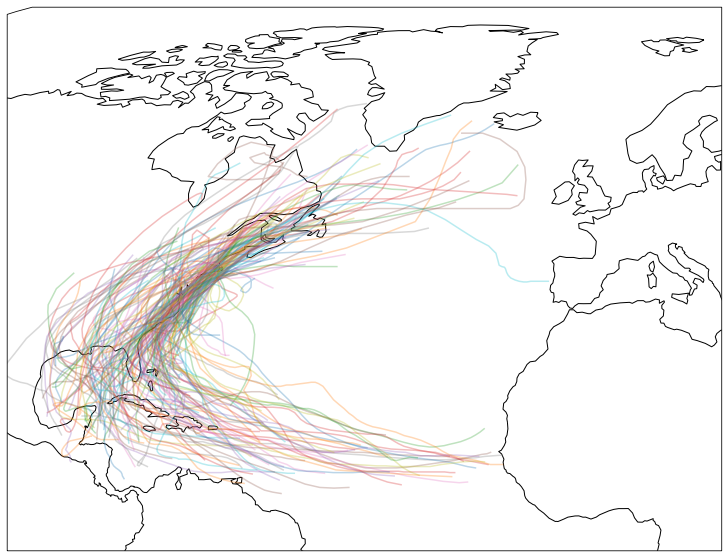

In [155]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.coastlines()

ax.set_extent([-100, 20, 0, 90], crs=ccrs.Geodetic())
#ax.set_global()

ax.plot(-71.186996, 41.966770, 'o', transform=ccrs.Geodetic())

sum = 0
for key in BOXhurdat:
    if statusNearLocation(BOXhurdat[key], -71.186996, 41.966770) in ['TD', 'HU', 'TS', 'SS', 'EX']:
        #if BOXhurdat[key]['idcode'] == 'AL051961':
        plotStorm(BOXhurdat[key]['data']['lon'], BOXhurdat[key]['data']['lat'], ax)
    sum +=1
    
print(f'{sum} storms plotted')
    
plt.show()

43 storms plotted


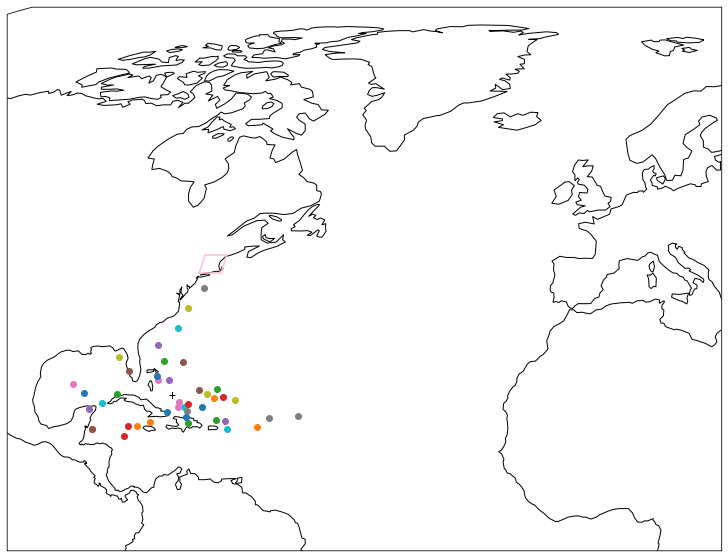

In [243]:
#potential todo: use a kent distribution rather than what I'm doing now

def plotTMinusPosition(hurdat, tMinus, stormType, lon_min=-180, lon_max=180, lat_min=-90, lat_max=90):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    ax.coastlines()

    ax.set_extent([-100, 20, 0, 90], crs=ccrs.Geodetic())
    #ax.set_global()



    position_list = []
    lon_list = []
    lat_list = []
    storm_list = []
    
    for key in hurdat:
        position = positionBeforeLandfall(hurdat[key], tMinus, lon_min, lon_max, lat_min, lat_max)

        if position is not None:
            position_list.append(position[0])
            lon_list.append(position[0][0])
            lat_list.append(position[0][1])
            storm_list.append(position[1])


    count = 0
    lon_sum = 0
    lat_sum = 0
    for sLon, sLat, storm in zip(lon_list, lat_list, storm_list):
        if statusNearLocation(storm, lon_min, lat_min) in stormType:
            ax.plot(sLon, sLat, 'o', transform=ccrs.Geodetic(), label = storm['idcode'])
            lon_sum += sLon
            lat_sum += sLat
            count +=1
    avg_position = (lon_sum / count, lat_sum / count)
    
    ax.plot([lon_min, lon_max], [lat_min, lat_min], transform=ccrs.PlateCarree(), color = 'pink')
    ax.plot([lon_min, lon_max], [lat_max, lat_max], transform=ccrs.PlateCarree(), color = 'pink')
    ax.plot([lon_max, lon_max], [lat_min, lat_max], transform=ccrs.PlateCarree(), color = 'pink')
    ax.plot([lon_min, lon_min], [lat_min, lat_max], transform=ccrs.PlateCarree(), color = 'pink')
    
    ax.plot(avg_position[0], avg_position[1], '+', transform=ccrs.Geodetic(), color = 'black')
    
    #ax.legend()
            

    print(f'{count} storms plotted')
    
    plt.show()
    
plotTMinusPosition(hurdat, 120, ['TD', 'HU', 'TS', 'SS', 'EX'], lon_min=-74, lon_max=-70, lat_min=41.25, lat_max=44)